In [1]:
import json
from pathlib import Path
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot: title={'center': 'Positioning'}, xlabel='timestamp', ylabel='volatility_exposure'>

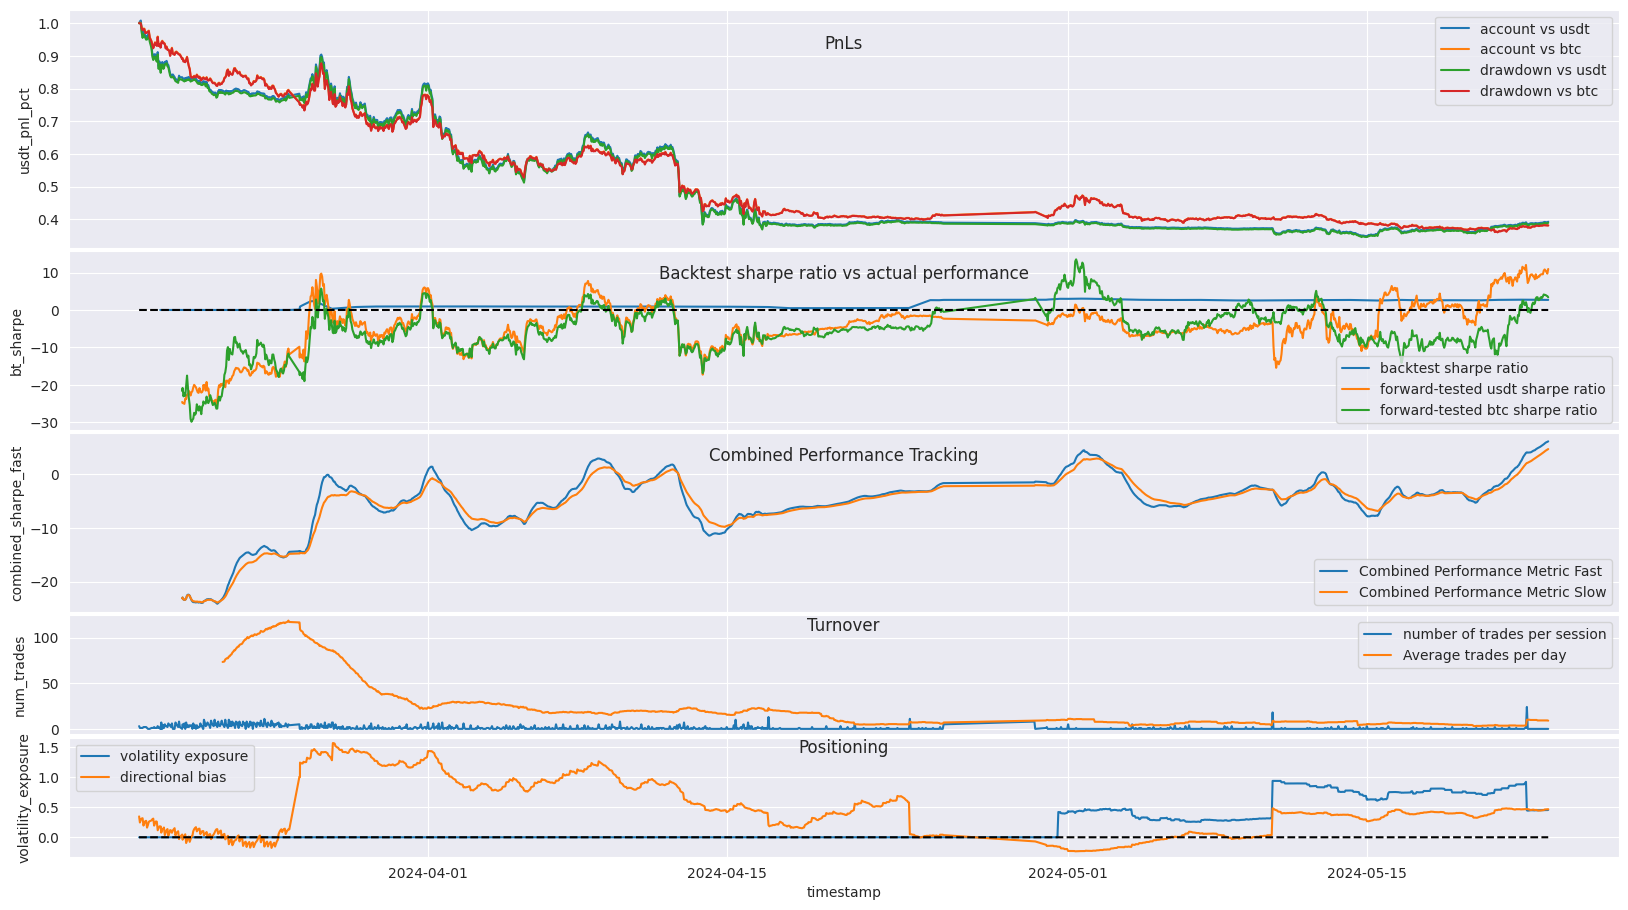

In [58]:
# TODO i want drawdown statistics like max dd, avg dd, max dd duration and avg dd duration and current dd duration - for the backtest and the live trading so i can compare

with open(Path("/home/ross/coding/pi_3/modular_trader/continuous/records/session.json"), 'r') as file:
    session_records = json.load(file)

for s in session_records:
    if s.get('volatility_exposure') is None:
        s['volatility_exposure'] = 0.0
    elif s.get('volatility_exposure') > 10:
        s['volatility_exposure'] = 0.9349222790015471

session_records_2 = [s for s in session_records if s.get('bt_sharpe')]
session_records_3 = [s for s in session_records if s.get('volatility_exposure')]

sr = pl.from_dicts(session_records).select(['timestamp', 'usdt_net', 'btc_net', 'trades'])
sr_2 = pl.from_dicts(session_records_2)['bt_sharpe']
sr_3 = pl.from_dicts(session_records_3)['volatility_exposure']
allos = [s[f"{s.get('port_weights', 'flat')}_allocations"] for s in session_records]
bias = pl.Series([sum(z.values()) for z in allos])
pred_exp = pl.Series([sum([abs(v) for v in z.values()]) for z in allos]) * 2

sr_2 = pl.Series([0.0] * (len(sr) - len(sr_2))).extend(sr_2)
sr_3 = pl.Series([0.0] * (len(sr) - len(sr_3))).extend(sr_3)

sharpe_lb = 168 # 168 = 1 week, 720 = 30 days, 2190 = 1Q, 8760 = 1 year
sr = sr.with_columns(
    pl.col('timestamp').mul(1000).cast(pl.Int64).cast(pl.Datetime(time_zone='UTC', time_unit='ms')),
    pl.col('usdt_net').truediv(sr.item(0, 'usdt_net')).alias('usdt_pnl_pct'),
    pl.col('btc_net').truediv(sr.item(0, 'btc_net')).alias('btc_pnl_pct'),
    pl.col('usdt_net').pct_change().ewm_mean(span=sharpe_lb, min_periods=48).mul(8760).truediv(pl.col('usdt_net').pct_change().ewm_std(span=sharpe_lb, min_periods=48).mul(92)).alias('usdt_sharpe'),
    pl.col('btc_net').pct_change().ewm_mean(span=sharpe_lb, min_periods=48).mul(8760).truediv(pl.col('btc_net').pct_change().ewm_std(span=sharpe_lb, min_periods=48).mul(92)).alias('btc_sharpe'),
    pl.lit(1.0).sub(pl.col('usdt_net').rolling_max(window_size=100_000, min_periods=1).sub(pl.col('usdt_net')).truediv(pl.col('usdt_net').rolling_max(window_size=100_000, min_periods=1))).alias('usdt_dd'),
    pl.lit(1.0).sub(pl.col('btc_net').rolling_max(window_size=100_000, min_periods=1).sub(pl.col('btc_net')).truediv(pl.col('btc_net').rolling_max(window_size=100_000, min_periods=1))).alias('btc_dd'),
    pl.col('trades').alias('num_trades'),
    pl.col('trades').rolling_sum(96).truediv(4).alias('avg_trades'),
    sr_2.rolling_mean(24).alias('bt_sharpe'),
    sr_3.alias('volatility_exposure'),
    bias.alias('bias'),
    # pred_exp.alias('pred_exp')
).tail(2190)

sr = sr.with_columns(
    pl.col('btc_sharpe').add(pl.col('usdt_sharpe')).truediv(2).ewm_mean(span=24).alias('combined_sharpe_fast'),
    pl.col('btc_sharpe').add(pl.col('usdt_sharpe')).truediv(2).ewm_mean(span=48).alias('combined_sharpe_slow')
)

fig, ax = plt.subplots(nrows=5, figsize=(20, 11), gridspec_kw=dict(height_ratios=[4, 3, 3, 2, 2]), sharex=True)
fig.subplots_adjust(hspace = 0.02)
ax[0].set_title('PnLs', y=0.8)
ax[1].set_title('Backtest sharpe ratio vs actual performance', y=0.8)
ax[2].set_title('Combined Performance Tracking', y=0.8)
ax[3].set_title('Turnover', y=0.8)
ax[4].set_title('Positioning', y=0.8)

sns.lineplot(data=sr, x='timestamp', y='usdt_pnl_pct', label='account vs usdt', ax=ax[0])
sns.lineplot(data=sr, x='timestamp', y='btc_pnl_pct', label='account vs btc', ax=ax[0])
sns.lineplot(data=sr, x='timestamp', y='usdt_dd', label='drawdown vs usdt', ax=ax[0])
sns.lineplot(data=sr, x='timestamp', y='btc_dd', label='drawdown vs btc', ax=ax[0])

sns.lineplot(data=sr, x='timestamp', y='bt_sharpe', label='backtest sharpe ratio', ax=ax[1])
sns.lineplot(data=sr, x='timestamp', y='usdt_sharpe', label='forward-tested usdt sharpe ratio', ax=ax[1])
sns.lineplot(data=sr, x='timestamp', y='btc_sharpe', label='forward-tested btc sharpe ratio', ax=ax[1])
sns.lineplot(data=sr, x='timestamp', y=0, color='black', linestyle='--', ax=ax[1])

sns.lineplot(data=sr, x='timestamp', y='combined_sharpe_fast', label='Combined Performance Metric Fast', ax=ax[2])
sns.lineplot(data=sr, x='timestamp', y='combined_sharpe_slow', label='Combined Performance Metric Slow', ax=ax[2])

sns.lineplot(data=sr, x='timestamp', y='num_trades', label='number of trades per session', ax=ax[3])
sns.lineplot(data=sr, x='timestamp', y='avg_trades', label='Average trades per day', ax=ax[3])

sns.lineplot(data=sr, x='timestamp', y='volatility_exposure', label='volatility exposure', ax=ax[4])
sns.lineplot(data=sr, x='timestamp', y='bias', label='directional bias', ax=ax[4])
# sns.lineplot(data=sr, x='timestamp', y='pred_exp', label='predicted exposure', ax=ax[4])
sns.lineplot(data=sr, x='timestamp', y=0, color='black', linestyle='--', ax=ax[4])

# statistics
